# Zyfra: Gold Recovery Modeling

## Introduction

This project on behalf of Zyfra is tasked with developing a model capable of predicting the amount of gold recovered from gold ore, based on purification data. The model will help to optimize production and eliminate parameters that might be hindering gold recovery in the current process.

Provided data consists of three data sets for gold aquisitions which underwent the purification process; a source dataset, one training and one test set. Features available in the data sets indicate input and output variables of the purification process such as:

- Metals input feed size particles
- Output concentrate and tail data for all purification stages.
- Air levels during process.
- Chemical activator levels during process.

Our targets for this study are `final.output.recovery` and `rougher.output.recovery` which describe the **final** and **rougher** outputs in gold recovery during the process. 

In [1]:
# Import nessecary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score

#### Load Data

In [2]:
# Load datasets into variables
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

### View Data

We will view each dataset, what information is contained in each and how they differ from each-other.

In [3]:
# View full data info
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [4]:
# View full data
gold_recovery_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
# View training info
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
# View train data
gold_recovery_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [7]:
# View test info
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [8]:
# View test data
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


### Recovery Calucation

Using our training set, we will ensure output recovery is calculated correctly by creating a function, that obtains a mean absolute error between calculations and features values.

In [9]:
# Create recovery formula function
gold_recovery_validate = gold_recovery_train.copy()
gold_recovery_validate.dropna(inplace=True)

def calculate_recovery_MAE(data):
    
    # Identify components: concentrate, feed, tails
    F = data["rougher.input.feed_au"]
    C = data["rougher.output.concentrate_au"]
    T = data["rougher.output.tail_au"]
    
    # Calculate gold recovery
    recovery = ((C*(F-T)) / (F*(C-T))) * 100
    
    # Obtain mean absolute error 
    recovery_MAE = mean_absolute_error(data['rougher.output.recovery'], recovery)
    
    return recovery_MAE

# Apply function/view result
rougher_recovery_MAE = calculate_recovery_MAE(gold_recovery_validate)
print(f'MAE of calculated recovery: {rougher_recovery_MAE}')

MAE of calculated recovery: 9.460144184559453e-15


Recovery MAE lends a considerably low value indicating output recovery is being calculated correctly according to the provided formula.

#### Data Preprocessing

Date column in training set will be dropped as it is not relevant to the study.

In [10]:
# Drop date column
gold_recovery_train.drop("date", axis=1, inplace=True)

Full and training datasets both show 87 features present in datasets with varying number of gold ore aquisitions. Test set shows 53 features present and 5856 aquisitions. All data sets present varying degress of null-values in diverse feature columns.

In [11]:
# Obatin null_value percentages
def missing_percentage(data):
    missing_values_count = data.isnull().sum().sum()
    
    return (missing_values_count / data.shape[0]) * 100

# Print null-value percentages 
print(f'gold_recovery_full null-value percentage: {missing_percentage(gold_recovery_full):.2f}%')
print(f'gold_recovery_train null-value percentage: {missing_percentage(gold_recovery_train):.2f}%')
print(f'gold_recovery_test null-value percentage: {missing_percentage(gold_recovery_test):.2f}%')

gold_recovery_full null-value percentage: 161.06%
gold_recovery_train null-value percentage: 179.83%
gold_recovery_test null-value percentage: 40.30%


In [16]:
# Reviewer's code 3

gold_recovery_full.isna().mean().sum()

1.61062687092798

In [58]:
# Drop missing values
gold_recovery_full[['final.output.recovery', 'rougher.output.recovery']].dropna(inplace=True)
gold_recovery_train[['final.output.recovery', 'rougher.output.recovery']].dropna(inplace=True)

# fill missing values
gold_recovery_full.ffill(inplace=True)
gold_recovery_train.ffill(inplace=True)
gold_recovery_test.ffill(inplace=True)

# View new dataset shapes
print(f'{gold_recovery_full.shape}\n{gold_recovery_train.shape}\n{gold_recovery_test.shape}')

(22716, 87)
(16860, 86)
(5856, 53)


/tmp/ipykernel_36/178104325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_recovery_full[['final.output.recovery', 'rougher.output.recovery']].dropna(inplace=True)
/tmp/ipykernel_36/178104325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_recovery_train[['final.output.recovery', 'rougher.output.recovery']].dropna(inplace=True)


Null-values are shown to comprise a large portion of our data, so we cannot ignore these values as they will create noise in our model. As stated parameters that are next each each other in terms of date/time are similar, we will fill missing feature values using `ffill`. We have handled zero values replacing them with the median.

### Feature Analysis

The available test set shows 34 features less than the full and training sets. We must look at what these missing features are and what role they play in the data.

In [14]:
# create data columns sets
recovery_train_features = set(gold_recovery_train.columns)
recovery_test_features = set(gold_recovery_test.columns)

# obtain missing features from test set
missing_features = recovery_train_features - recovery_test_features
features_list = list(missing_features)
recovery_test_missing = pd.DataFrame(features_list, columns=['missing from test data'])
recovery_test_missing

,missing from test data
0,rougher.output.tail_sol
1,secondary_cleaner.output.tail_pb
2,final.output.tail_ag
3,rougher.calculation.sulfate_to_au_concentrate
4,final.output.concentrate_au
5,rougher.output.concentrate_au
6,primary_cleaner.output.concentrate_pb
7,rougher.output.tail_pb
8,primary_cleaner.output.concentrate_sol
9,secondary_cleaner.output.tail_sol


Results show **output and tail recovery data** for flotation as well as primary and secondary cleaner processes is not present in test set. **Calculation** characteristics during floation process are also not present.

## EDA

### Metal Concentrations /  Cleaner Stage

In order to maximize recovery we must look at the different components present in the each stage. To start we will look at the variation in concentration of metals depending on the purification stage.  

In [15]:
# Create function to view averages and metals distribution
def plot_metals_dist(title, df, metal_1, metal_2, metal_3, metal_4):
    print(f"silver average: {df[metal_1].mean():.2f}\nlead average: {df[metal_2].mean():.2f}\ngold average: {df[metal_3].mean():.2f}") 

    df[metal_1].plot(kind='hist', color='silver', alpha=0.5)
    df[metal_2].plot(kind='hist', color='gray', alpha=0.5)
    df[metal_3].plot(kind='hist', color='gold', alpha=0.5)
    df[metal_4].plot(kind='hist', color='tan', alpha=0.5)
    
    plt.title(title)
    plt.legend(['silver', 'lead', 'gold', 'sol'])
    plt.show()

silver average: 7.80
lead average: 3.19
gold average: 7.14


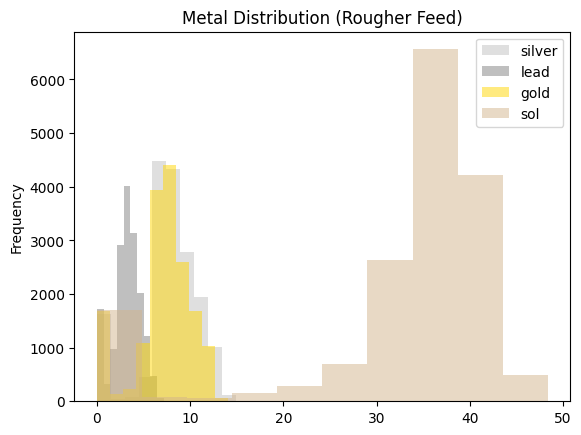

silver average: 10.54
lead average: 6.86
gold average: 17.34


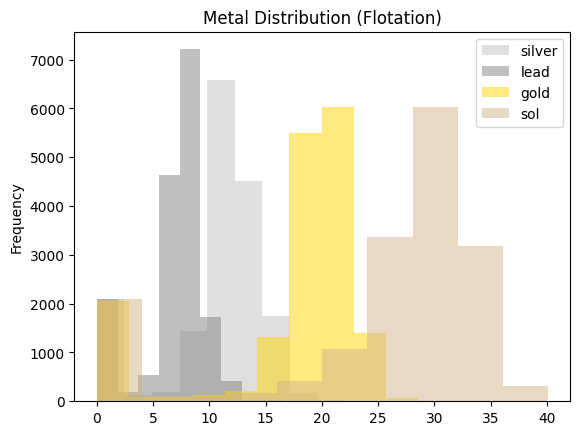

silver average: 7.39
lead average: 8.49
gold average: 29.04


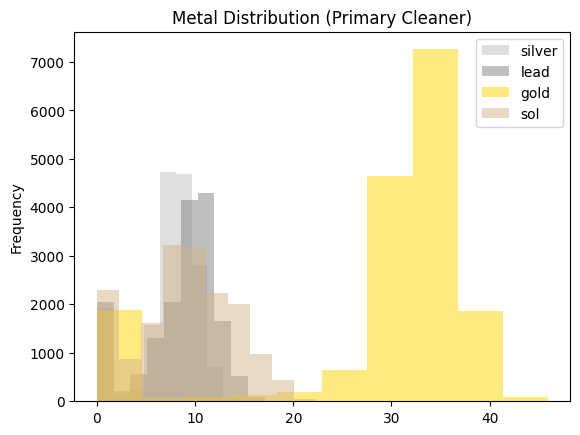

silver average: 4.70
lead average: 9.08
gold average: 39.32


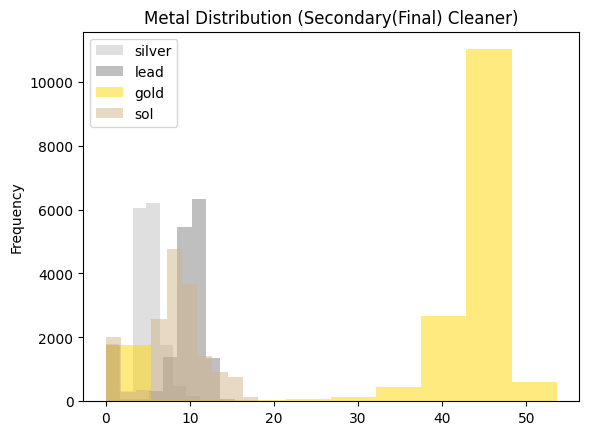

In [16]:
# View metals initial feed
plot_metals_dist("Metal Distribution (Rougher Feed)", gold_recovery_train, 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.input.feed_sol')

# View metals distribution after flotation
plot_metals_dist("Metal Distribution (Flotation)", gold_recovery_train, 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au', 'rougher.output.concentrate_sol')

# View metals distribution after primary cleaner process
plot_metals_dist("Metal Distribution (Primary Cleaner)", gold_recovery_train, 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_sol')

# View metals distribution after secondary cleaner process
plot_metals_dist("Metal Distribution (Secondary(Final) Cleaner)", gold_recovery_train, 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.concentrate_sol')

Data shows distribution of higher concentration of gold per aquisition increases as purification stages advance, while lead and silver decrease. Averages of metal concentration for gold and silver seem to follow this pattern except for lead whose average increase slightly by the end of the cleaner process. Histograms show a certain percentage of aquisitions yield **values of zero** throughout the purification stages both in gold and sol, we will need to look into this further.

### Feed Size Comparision

Before model building and evaluation we must ensure particle size fed for both training and test sets is similar to ensure better results.

In [17]:
# Create function to view feed size distributions
def plot_feed_dist(title, df_1, df_2, feed_size, bins, xlim):
    print(f"train feed size average: {df_1[feed_size].describe()}\ntest feed size average: {df_2[feed_size].describe()}") 
    
    df_1[feed_size].plot(kind='hist', color='red', bins=bins, alpha=0.5, xlim=xlim)
    df_2[feed_size].plot(kind='hist', color='green', bins=bins, alpha=0.5, xlim=xlim)
    
    plt.title(title)
    plt.legend(['train', 'test'])
    plt.show()

train feed size average: count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64
test feed size average: count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


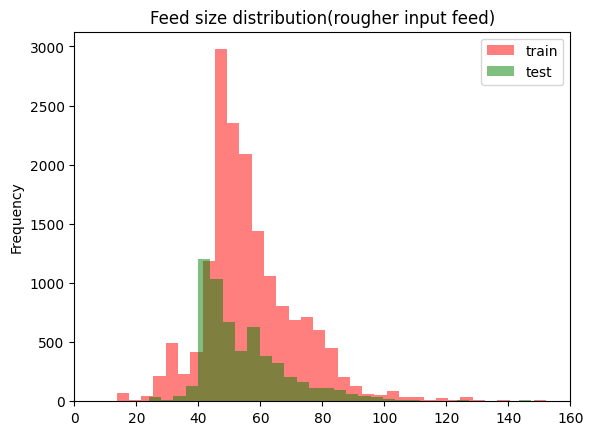

train feed size average: count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64
test feed size average: count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


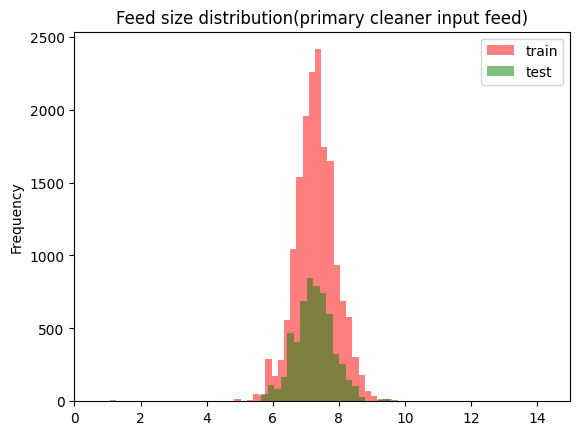

In [18]:
# Plot raw feed size distribution
plot_feed_dist("Feed size distribution(rougher input feed)", gold_recovery_train, gold_recovery_test, 'rougher.input.feed_size', 120, (0, 160))

# Plot primary cleaner feed size distribution
plot_feed_dist("Feed size distribution(primary cleaner input feed)", gold_recovery_train, gold_recovery_test, 'primary_cleaner.input.feed_size', 50, (0, 15))

Data shows feed size distribution for rougher input feed to have similar feed size distribution between train and test sets, however raw feed size does exhibit **outlier data** with values reaching up to 484. Primary cleaner feed distributions appear to follow similar values between sets except for a relatively small number of outliers close to zero value.

### Abnormal Value Removal

After viewing the distribution of substances at all stages, there were several abnormal values identified in metal distributions as well as feed particle size. These abnormalities consist of: 

- "Zero" values present in metal distrubution for gold and sol during all stages of purification.
- Outliers present in feed particle size.

Before constructing models we will eliminate these abnormalities as they may cause distortion in the data.

In [19]:
# Define columns to remove values
metals_columns = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']
feed_size_columns = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

# Drop rows with abnormal values
drop_zeros = gold_recovery_train[~(gold_recovery_train[metals_columns] == 0).any(axis=1)]
gold_recovery_train_cleaned = drop_zeros[~(drop_zeros[feed_size_columns] > 120).any(axis=1)]
gold_recovery_test_cleaned = gold_recovery_test[~(gold_recovery_test[feed_size_columns] < 4).any(axis=1)]

Columns kept in training set have been set as not equal to zero and feed size columns to not exceed value of 120 as displayed in histograms. Test data feed particle size outliers below 4 have been dropped.

In [20]:
# View shape of cleaned data and verify values removal
zeros_count = (gold_recovery_train_cleaned[metals_columns] == 0).sum()
display(gold_recovery_test_cleaned[feed_size_columns].min())
display(gold_recovery_train_cleaned[feed_size_columns].max())
zeros_count

rougher.input.feed_size            5.741424
primary_cleaner.input.feed_size    5.650000
dtype: float64

rougher.input.feed_size            119.664018
primary_cleaner.input.feed_size     10.470000
dtype: float64

rougher.output.concentrate_au             0
primary_cleaner.output.concentrate_au     0
final.output.concentrate_au               0
rougher.output.concentrate_sol            0
primary_cleaner.output.concentrate_sol    0
final.output.concentrate_sol              0
dtype: int64

Data appears corrected and ready for use.

## Model Building, Validation and Testing

The evaluation metric for this study is sMAPE. Upon calculation of sMAPE for both final and rougher recovery data a **final sMAPE** will be calcuated as a weighted figure to describe total error in model prediction. Accuracy of model will be validaded using **cross-validation**.

### sMAPE Function

In [21]:
# Create function to calculate sMAPE
def calculate_sMAPE(target_values, prediction_values):
    numerator = np.abs(target_values - prediction_values)
    denominator = (np.abs(target_values) + np.abs(prediction_values)) / 2
    return np.mean(numerator / denominator) * 100

# Create funciton to calculate final weighted sMAPE
def final_sMAPE(rougher, final):
    return 0.25 * rougher + 0.75 * final

### Model Building

Model building for gold recovery will focus on testing for random forest regression and linear regression. Results are to be tested using the provided test set to obtain the lowest sMAPE value possible.

As stated before, our provided test set does not include output values, we will remove these values leaving only the require target values for training.

In [22]:
# Remove output values and keep target values
exclude_targets = ['final.output.recovery', 'rougher.output.recovery']
columns_to_drop = [x for x in features_list if x not in exclude_targets]
gold_recovery_train_cleaned.drop(columns=columns_to_drop, inplace=True)

# Define feature/target data
features = gold_recovery_train_cleaned.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target = gold_recovery_train_cleaned[['final.output.recovery', 'rougher.output.recovery']]
gold_recovery_train_cleaned.shape

/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(14685, 54)

In [23]:
# Training/Validation data split rougher/final
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
print(f'features train shape: {features_train.shape}\nfeatures train shape: {features_valid.shape}\ntarget train shape: {target_train.shape}\ntarget train shape: {target_valid.shape}')

features train shape: (11013, 52)
features train shape: (3672, 52)
target train shape: (11013, 2)
target train shape: (3672, 2)


#### Linear Regression

In [24]:
# Train linear regression model
modelLR = LinearRegression()
modelLR.fit(features_train, target_train)
predictionsLR = modelLR.predict(features_valid)
predictionsLR = pd.DataFrame(predictionsLR) # Convert predicitons array to Dataframe

# Calculate rougher/final sMAPE
sMAPE_rougherLR = calculate_sMAPE(target_valid.iloc[:, 1], predictionsLR.iloc[:, 1])
sMAPE_finalLR = calculate_sMAPE(target_valid.iloc[:, 0], predictionsLR.iloc[:, 0])

# Obatin final sMAPE for linear regression model 
final_sMAPE_LR = final_sMAPE(sMAPE_rougherLR, sMAPE_finalLR)

# Evaluate model using cross-validation
modelLR = LinearRegression()
scoresLR = cross_val_score(modelLR, features, target, cv=5)
final_scoreLR = scoresLR.mean()
print(f'final sMAPE Linear Regression: {final_sMAPE_LR:.2f}%\ncross validation score average: {final_scoreLR:.2f}')

final sMAPE Linear Regression: 12.84%
cross validation score average: -0.25


#### Random Forest Regressor

In [25]:
# Train random forest regression model
best_est = 0
best_depth = 0
best_final_sMAPE_RF = 15
for est in range(60, 80, 5):
    for depth in range(20, 25):
        modelRF = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        modelRF.fit(features_train, target_train)
        predictionsRF = modelRF.predict(features_valid)
        predictionsRF = pd.DataFrame(predictionsRF)
        sMAPE_rougherRF = calculate_sMAPE(target_valid.iloc[:, 1], predictionsRF.iloc[:, 1])
        sMAPE_finalRF = calculate_sMAPE(target_valid.iloc[:, 0], predictionsRF.iloc[:, 0])
        final_sMAPE_RF = final_sMAPE(sMAPE_rougherRF, sMAPE_finalRF)
        if final_sMAPE_RF < best_final_sMAPE_RF: # Find best model hyperparameters
            best_est = est
            best_depth = depth
            best_final_sMAPE_RF = final_sMAPE_RF

# Evaluate model using cross-validation
modelRF = RandomForestRegressor(n_estimators=65, max_depth=24, random_state=12345)
scoresRF = cross_val_score(modelRF, features, target, cv=5)
final_scoreRF = scoresRF.mean()

print(f'best estimators: {best_est}\nbest depth: {best_depth}\nfinal sMAPE Random Forest Regressor: {best_final_sMAPE_RF:.2f}%\ncross validation score average: {final_scoreRF:.2f}')

best estimators: 60
best depth: 20
final sMAPE Random Forest Regressor: 13.88%
cross validation score average: -0.12


### Model testing

As stated before the provided test data does not contain our target values or any output data used to calculate recovery features. To test our model using the provided data we will add the missing target data to our test set using the full data set to extract and add the output recovery variables. 

In [27]:
# Extract missing features from full dataset and merge with test data
columns_to_merge = ['date', 'final.output.recovery', 'rougher.output.recovery']
recovery_data = gold_recovery_full[columns_to_merge]
test_output_merge = pd.merge(gold_recovery_test_cleaned, recovery_data, how='left', on='date')

# process data according to analysis
test_output_merge.dropna(inplace=True)
test_output_merge.drop('date', axis=1, inplace=True)
test_output_merge.shape

(5852, 54)

#### Test Best Model

In [28]:
# Define features/target
features_test = test_output_merge.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target_test = test_output_merge[['final.output.recovery', 'rougher.output.recovery']]

# Test model
modelLR_test = LinearRegression()
modelLR_test.fit(features_train, target_train)
predictionsRF_test = modelLR_test.predict(features_test)
predictionsRF_test = pd.DataFrame(predictionsRF_test)
sMAPE_rougher_test = calculate_sMAPE(target_test.iloc[:, 1], predictionsRF_test.iloc[:, 1])
sMAPE_final_test = calculate_sMAPE(target_test.iloc[:, 0], predictionsRF_test.iloc[:, 0])
final_sMAPE_test = final_sMAPE(sMAPE_rougher_test, sMAPE_final_test)

print(f'final sMAPE test data: {final_sMAPE_test:.2f}%')

final sMAPE test data: 12.94%


## Conclusion

Linear regression model yields best results with an sMAPE of 12.94% on test set. Results suggest abnormal values of such as:

- **zero values** present in output of gold during purification
- **outlier values** in feed particle size.
  
Were hindering best performance of prediction models. Removing these abnormalities did in fact lower sMAPE and improve model. Further study is warranted to understand how these "zero values" are appearing as output during purfication. However based on results, improved consistency of feed particle size input not exceeding majority or minority distribution ranges (avoiding outliers), should lead to higher gold recovery. 